In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report,precision_score,confusion_matrix,accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
%matplotlib inline 

import scipy.stats as stats
import seaborn as sns

Changement des données et prétraitement

In [6]:
df = pd.read_csv('C:/Users/frobi/OneDrive/Documents/GitHub/dec23_cds_co2/data/processed/FinalData.csv', index_col=0)
df.drop_duplicates(inplace=True)

df_Categorielle = df.drop(['Mt', 'Ewltp (g/km)', 'W (mm)', 'At1 (mm)', 'ec (cm3)', 'ep (KW)',
                           'Erwltp (g/km)', 'Fuel consumption '], axis=1)
df_quantitative = df[['Mt', 'Ewltp (g/km)', 'W (mm)', 'At1 (mm)', 'ec (cm3)', 'ep (KW)',
                       'Erwltp (g/km)', 'Fuel consumption ']]
df_quantitative = df_quantitative.fillna(df_quantitative.std()) 

df_Categorielle = df_Categorielle.join(pd.get_dummies(df_Categorielle[['Country','Ct','Ft','Cr']]))
df_Categorielle = df_Categorielle.drop(['Country','Ct','Ft','Cr'],axis=1)

le = LabelEncoder()
df_Categorielle['Mk'] = le.fit_transform(df_Categorielle['Mk'])
df_Categorielle['Mh'] = le.fit_transform(df_Categorielle['Mh'])
df_Categorielle['IT'] = le.fit_transform(df_Categorielle['IT'])

df_Final = df_Categorielle.join(df_quantitative)

data = df_Final.drop('Ewltp (g/km)',axis=1)
target = df_Final['Ewltp (g/km)']

préparation des données d'entrainement et de test

In [7]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.25, random_state=123)
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Random forest Regressor

c:\DEV\Anaconda\envs\dec23CDSCO2\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


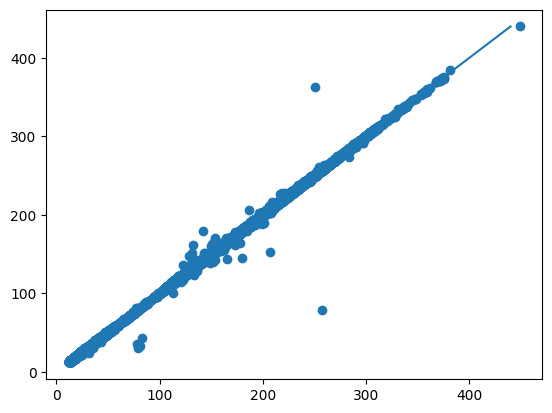

In [8]:
rf = RandomForestRegressor(n_estimators=100,random_state=123)
rf.fit(X_train_scaled,y_train)

y_pred_rf = rf.predict(X_test_scaled)
rf.score(X_test, y_test)

plt.scatter(y_pred_rf,y_test)
plt.plot((y_test.min(), y_test.max()), (y_test.min(), y_test.max()));
# changer les couleurs

#print(classification_report(y_test, y_pred_rf))
#Classification metrics can't handle a mix of multiclass and continuous targets

Feature importance Random Forest

In [9]:
#Feature importance GradientBoostingRegressor
feats = {}
for feature, importance in zip(data.columns, rf.feature_importances_):
    feats[feature] = importance

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Importance'})
importances.sort_values(by='Importance', ascending=False)

,Importance
Fuel consumption,9.633301e-01
Ft_diesel,2.046718e-02
Mt,1.199004e-02
Ft_petrol,2.198279e-03
ep (KW),7.390193e-04
At1 (mm),4.274811e-04
Ft_ng,2.768778e-04
W (mm),1.624106e-04
Ft_petrol/electric,1.374973e-04
ec (cm3),8.831965e-05


 “absolute_error” is significantly slower than when using “squared_error”

(max_depth, criterion, n_estimators)
param_grid = {
    'n_estimators': [50,100,200],
    'criterion' : ['squared_error', 'friedman_mse', 'poisson']    
    'max_depth': [None, 10, 20, 30],
}

6 min 12
cv = 2 => +-10 min
cv= 3 => 17 min 48


In [20]:
param_grid = {
    'n_estimators': [100,150],
    'criterion' : ['squared_error','friedman_mse','poisson'],
    'max_depth': [10, 20, 30],
}
grid_clf = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, n_jobs=-1,
                        cv=3, verbose=1,refit= True)
grille = grid_clf.fit(X_train_scaled,y_train)
print(pd.DataFrame.from_dict(grille.cv_results_).loc[:,['params', 'mean_test_score']])

print('le meilleur paramètre de RandomForestRegressor est :',grid_clf.best_params_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
                                               params  mean_test_score
0   {'criterion': 'squared_error', 'max_depth': 10...         0.999282
1   {'criterion': 'squared_error', 'max_depth': 10...         0.999279
2   {'criterion': 'squared_error', 'max_depth': 20...         0.999529
3   {'criterion': 'squared_error', 'max_depth': 20...         0.999537
4   {'criterion': 'squared_error', 'max_depth': 30...         0.999512
5   {'criterion': 'squared_error', 'max_depth': 30...         0.999509
6   {'criterion': 'friedman_mse', 'max_depth': 10,...         0.999276
7   {'criterion': 'friedman_mse', 'max_depth': 10,...         0.999272
8   {'criterion': 'friedman_mse', 'max_depth': 20,...         0.999530
9   {'criterion': 'friedman_mse', 'max_depth': 20,...         0.999532
10  {'criterion': 'friedman_mse', 'max_depth': 30,...         0.999506
11  {'criterion': 'friedman_mse', 'max_depth': 30,...         0.999515
12  {'criterion'

In [22]:
print('le meilleur paramètre de RandomForestRegressor est :',grid_clf.best_params_)

le meilleur paramètre de RandomForestRegressor est : {'criterion': 'poisson', 'max_depth': 20, 'n_estimators': 150}


Gradiient boosting

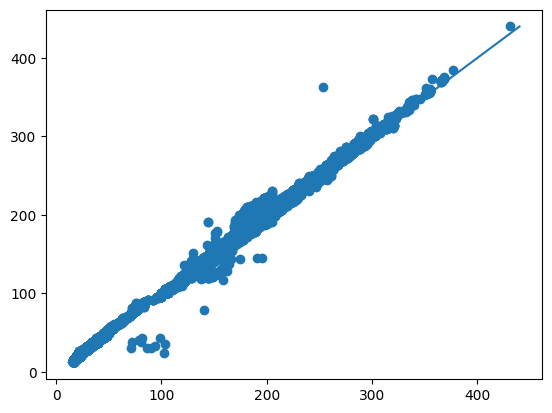

In [5]:
gbr = GradientBoostingRegressor(random_state=0)
gbr.fit(X_train_scaled,y_train)
y_pred_gbr = gbr.predict(X_test_scaled)

#gbr.score(X_test, y_test)

plt.scatter(y_pred_gbr,y_test)
plt.plot((y_test.min(), y_test.max()), (y_test.min(), y_test.max()));
# changer les couleurs

print(classification_report(y_test, y_pred_gbr))


Feature Importance Gradient Boosting

In [6]:
#Feature importance GradientBoostingRegressor
feats = {}
for feature, importance in zip(data.columns, gbr.feature_importances_):
    feats[feature] = importance

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Importance'})
importances.sort_values(by='Importance', ascending=False)

,Importance
Fuel consumption,0.938629
Mt,0.042585
Ft_diesel,0.015438
Ft_lpg,0.000963
Ft_ng,0.000533
W (mm),0.000415
Ft_petrol/electric,0.000384
ep (KW),0.000298
ec (cm3),0.000265
Ft_petrol,0.000173


Logistic regression

c:\DEV\Anaconda\envs\DataScienceTest_101\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\DEV\Anaconda\envs\DataScienceTest_101\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\DEV\Anaconda\envs\DataScienceTest_101\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

        12.0       0.00      0.00      0.00        43
        13.0       0.22      0.30      0.26        64
        14.0       0.00      0.00      0.00        67
        15.0       0.26      0.59      0.36       162
        16.0       0.38      0.20      0.26       125
        17.0       0.23      0.33      0.27        84
        18.0       0.28      0.37      0.32       118
        19.0       0.73      0.14      0.24       153
        20.0       0.28      0.30      0.29       181
        21.0       0.18      0.11      0.13       156
        22.0       0.00      0.00      0.00       140
        23.0       0.00      0.00      0.00       322
        24.0       0.23      0.41      0.30       507
        25.0       0.00      0.00      0.00       362
        26.0       0.25      0.54      0.34       417
        27.0       0.16      0.26      0.20       543
        28.0       0.21      0.10      0.14       462
        29.0       0.20    

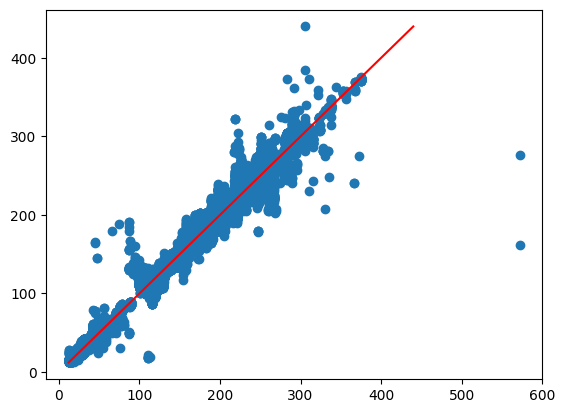

In [19]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_scaled,y_train)

y_pred_clf = clf.predict(X_test_scaled)

plt.scatter(y_pred_clf,y_test)
plt.plot((y_test.min(), y_test.max()), (y_test.min(), y_test.max()),'r');
# changer les couleurs
#print(pd.crosstab(y_test, y_pred_clf, rownames=['reel'], colnames=['Predicted']))
print(classification_report(y_test, y_pred_clf))

Feature importance 

In [23]:
#Feature importance GradientBoostingRegressor
feats = {}
for feature, importance in zip(data.columns, gbr.feature_importances_):
    feats[feature] = importance

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Importance'})
importances.sort_values(by='Importance', ascending=False)

,Importance
Fuel consumption,0.938629
Mt,0.042585
Ft_diesel,0.015438
Ft_lpg,0.000963
Ft_ng,0.000533
W (mm),0.000415
Ft_petrol/electric,0.000384
ep (KW),0.000298
ec (cm3),0.000265
Ft_petrol,0.000173


Grid search Logistic Regression

In [26]:
params_lr = {'solver': ['liblinear', 'lbfgs'],
             'C': [10**(i) for i in range(-4, 3)]}

gridcv = GridSearchCV(clf, param_grid=params_lr, scoring='accuracy', cv=3)

In [27]:
gridcv.fit(X_train,y_train)

pd.DataFrame(gridcv.cv_results_)[['params','mean_test_score','std_test_score']]
gridcv.best_params_

c:\DEV\Anaconda\envs\DataScienceTest_101\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
c:\DEV\Anaconda\envs\DataScienceTest_101\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\DEV\Anaconda\envs\DataScienceTest_101\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the d